## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(8, 9):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:35<00:00, 10.51it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_8"])
layer_hs_array.shape

(10000, 267264)

## Layer 8 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

# dim_reduced_vecs = layer_hs_array

random_projector = GaussianRandomProjection(random_state = 42)
dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 7894)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 7894)
(8000,)
(2000, 7894)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 7894D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.13 s
Outer iteration 0 / 10
  Iteration 19 (0.60 s, search 0.30 s): objective=2411.08 imbalance=1.040 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (1.21 s, search 0.59 s): objective=2410.92 imbalance=1.040 nsplit=0       
Outer iteration 2 / 10
  Iteration 19 (1.81 s, search 0.89 s): objective=2411.1 imbalance=1.046 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (2.41 s, search 1.18 s): objective=2405.37 imbalance=1.133 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (3.01 s, search 1.48 s): objective=2398.52 imbalance=1.477 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (3.61 s, search 1.77 s): objective=2353.24 imbalance=1.711 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (4.20 s, search 2.07 s): objective=2404.29 imbalance=1.184 ns

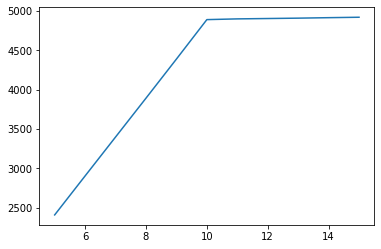

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 7894D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 0.05 s
Outer iteration 0 / 10
  Iteration 19 (1.24 s, search 0.60 s): objective=4862.17 imbalance=1.282 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (2.45 s, search 1.20 s): objective=4874.23 imbalance=1.298 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (3.66 s, search 1.80 s): objective=4887.45 imbalance=1.207 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 10
  Iteration 19 (4.86 s, search 2.40 s): objective=4876.79 imbalance=1.205 nsplit=0       
Outer iteration 4 / 10
  Iteration 19 (6.06 s, search 2.99 s): objective=4816.94 imbalance=2.513 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (7.29 s, search 3.59 s): objective=4864.53 imbalance=1.225 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (8.50 s, search 4.19 s): objective=4876.6 imbalance=1.180 nsplit=0

4887.45458984375

In [15]:
kmeans.centroids #cluster centers

array([[-0.00534362,  0.01140837,  0.03335991, ..., -0.00119827,
        -0.015866  , -0.00154624],
       [-0.02240047, -0.000899  , -0.00483788, ..., -0.01299104,
        -0.00589045,  0.00886801],
       [-0.01164224,  0.00471959,  0.02648833, ..., -0.00279145,
        -0.0308071 ,  0.00460022],
       ...,
       [-0.01564999, -0.00165765,  0.00138883, ..., -0.01443867,
        -0.00752233,  0.00023679],
       [-0.00634269,  0.00581276,  0.03217505, ..., -0.00187509,
        -0.01917604,  0.01106112],
       [-0.00593281,  0.00253605,  0.03358166, ..., -0.00304018,
        -0.02148795,  0.00454814]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

0.9999998
1.0000001
0.9999999
0.9999999
0.9999997
1.0
1.0
0.99999976
1.0000001
0.9999999


In [17]:
kmeans.obj #inertia at each iteration

array([3002.17675781, 4825.58105469, 4849.17773438, 4856.17529297,
       4858.53564453, 4859.69042969, 4860.36376953, 4860.7734375 ,
       4861.12744141, 4861.42724609, 4861.64453125, 4861.78515625,
       4861.87548828, 4861.95361328, 4862.02734375, 4862.07080078,
       4862.11132812, 4862.13476562, 4862.14941406, 4862.16992188,
       3010.62597656, 4836.640625  , 4853.78564453, 4862.22900391,
       4867.24169922, 4870.61376953, 4872.50097656, 4873.04931641,
       4873.34619141, 4873.55126953, 4873.68994141, 4873.84472656,
       4873.95166016, 4874.03613281, 4874.07861328, 4874.12744141,
       4874.15625   , 4874.1875    , 4874.21240234, 4874.22558594,
       3052.92016602, 4858.84570312, 4876.87255859, 4879.6484375 ,
       4880.77734375, 4882.00976562, 4883.37744141, 4884.0703125 ,
       4884.95947266, 4886.63574219, 4887.26904297, 4887.34619141,
       4887.38964844, 4887.4140625 , 4887.42626953, 4887.43115234,
       4887.43066406, 4887.44091797, 4887.43994141, 4887.45458

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

6    1568
4    1128
8    1009
9     928
1     903
7     701
3     545
5     478
0     430
2     310
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[3, 10, 10, 8, 1, 5, 9, 2, 7, 6]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 3, 1: 10, 2: 10, 3: 8, 4: 1, 5: 5, 6: 9, 7: 2, 8: 7, 9: 6}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 9,  2,  9, ...,  9, 10,  1])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.1675
Prompt 2 Accuracy:  0.11125
Prompt 3 Accuracy:  0.5375
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.4025
Prompt 6 Accuracy:  0.18
Prompt 7 Accuracy:  0.21625
Prompt 8 Accuracy:  0.115
Prompt 9 Accuracy:  0.22125
Prompt 10 Accuracy:  0.55125


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.25025


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

6    411
8    290
4    284
9    212
1    199
7    185
3    132
5    115
0    102
2     70
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 8,  2,  9, ..., 10,  1, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.105
Prompt 2 Accuracy:  0.065
Prompt 3 Accuracy:  0.51
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.435
Prompt 6 Accuracy:  0.2
Prompt 7 Accuracy:  0.235
Prompt 8 Accuracy:  0.11
Prompt 9 Accuracy:  0.24
Prompt 10 Accuracy:  0.485


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.2385


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

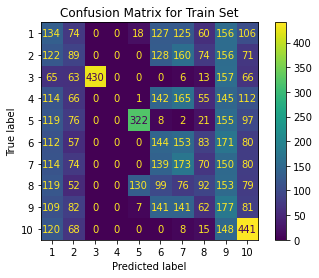

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

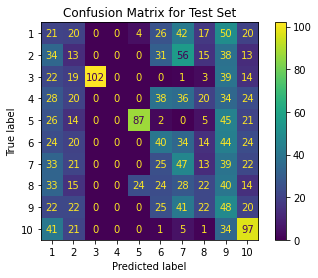

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()